## Time-varying volatility

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew, kurtosis
from scipy.optimize import minimize_scalar
import plotly.graph_objects as go

### Monte Carlo Paths

In [2]:
def GeometricBrownianMotion(S0, r, T, sigma, Nt, Np, rd = None):
    if rd: np.random.seed(rd)
    dt = T / Nt
    z = np.random.standard_normal(size = (Nt + 1, Np))
    x = np.exp((r - 0.5 * sigma ** 2) * dt + z * sigma * np.sqrt(dt))
    x[0, :] = 1
    S = np.full((Nt + 1, Np), S0) 
    S = np.multiply(S, np.cumprod(x, axis = 0))
    return S


def Heston(S0, r, T, sigmabar, rho, kappa, c, Nt, Np, rd = None):
    if rd: np.random.seed(rd)
    dt = T / Nt
    mu = np.array([0,0])
    cov = np.array([[1, rho],[rho,1]])
    z = np.random.multivariate_normal(mu, cov, size = (Nt, Np))
    S = np.zeros((Nt + 1, Np))
    V = np.zeros((Nt + 1, Np))
    S[0,:] = S0
    V[0,:] = sigmabar

    for t in range(1, Nt + 1):
        V[t,:] = np.abs(V[t-1,:] + kappa * (sigmabar - V[t-1,:]) * dt + z[t-1,:,0] * c * np.sqrt(V[t-1,:]) * np.sqrt(dt))
        S[t,:] = S[t-1,:] * np.exp((r - 0.5 * V[t,:]) * dt + z[t-1,:,1] * np.sqrt(V[t,:]) * np.sqrt(dt))

    return S, V

def Garch(S0, r, T, sigmabar, kappa, alpha, Nt, Np, rd = None):
    if rd: np.random.seed(rd)
    dt = T / Nt
    z = np.random.standard_normal(size = (Nt + 1, Np))
    S = np.zeros((Nt + 1, Np))
    V = np.zeros((Nt + 1, Np))
    S[0,:] = S0
    V[0,:] = sigmabar ** 2

    for t in range(1, Nt + 1):
        V[t,:] = np.abs(V[t-1,:] + kappa * (sigmabar - V[t-1,:]) + alpha * V[t-1,:] * (z[t,:] ** 2 - 1))
        S[t,:] = S[t-1,:] * np.exp((r - 0.5 * V[t,:]) * dt + z[t,:] * np.sqrt(V[t,:]) * np.sqrt(dt))

    return S, V

def Deterministic(S0, r, T, sigmabar, a, b, c, d, e, Nt, Np, rd = None):
    if rd: np.random.seed(rd)
    dt = T / Nt
    z = np.random.standard_normal(size = (Nt + 1, Np))
    S = np.zeros((Nt + 1, Np))
    S[0,:] = S0
    t = np.linspace(0, Nt, Nt + 1)
    V = sigmabar + a * (t / Nt) + b * (t / Nt) ** 2 + c * (t / Nt) ** 3 + d * (t / Nt) ** 4 + e * np.sin(8 * np.pi * t / Nt)
    V = np.tile(V, (Np, 1)).T

    for t in range(1, Nt + 1):
        S[t,:] = S[t-1,:] * np.exp((r - 0.5 * V[t-1,:]) * dt + z[t,:] * np.sqrt(V[t-1,:]) * np.sqrt(dt))

    return S, V

def PlotPricePaths(S, model):
    plt.figure(figsize=(10, 6))
    plt.plot(S[:, :min(100, S.shape[1])])
    plt.title(f'{model} Simulated Price Paths')
    plt.ylabel('Price')
    plt.xlabel('Time')
    plt.show()

def PlotVolatilityPaths(V, model):
    plt.figure(figsize = (10,6))
    plt.plot(np.sqrt(V[:,:min(100, V.shape[1])]))
    plt.title(f'{model} Simulated Volatility Paths')
    plt.ylabel('Volatility')
    plt.xlabel('Time')
    plt.show()

def PlotReturnDistribution(S, model):
    returns = pd.DataFrame(S).pct_change().to_numpy().ravel()
    returns = returns[~pd.isna(returns)]
    stats_text = (f'Mean: {returns.mean():.4f}\n'
                  f'Variance: {returns.var():.4f}\n'
                  f'Skewness: {skew(returns):.4f}\n'
                  f'Kurtosis: {kurtosis(returns):.4f}')

    plt.figure(figsize = (10,6))
    plt.hist(returns, bins = 'rice', alpha = 0.8)
    plt.title(f'{model} Distribution of Returns')
    plt.ylabel('Count')
    plt.xlabel('Return')
    plt.text(0.95, 0.95, stats_text, transform = plt.gca().transAxes, fontsize = 10,
             verticalalignment = 'top', horizontalalignment = 'right',
             bbox = dict(facecolor = 'white', edgecolor = 'white'))
    plt.show()

In [3]:
S0, r, T, Nt, Np = 100, 0.03, 1, 252, 10000
sigma = 0.2

#### Geometric Brownian Motion

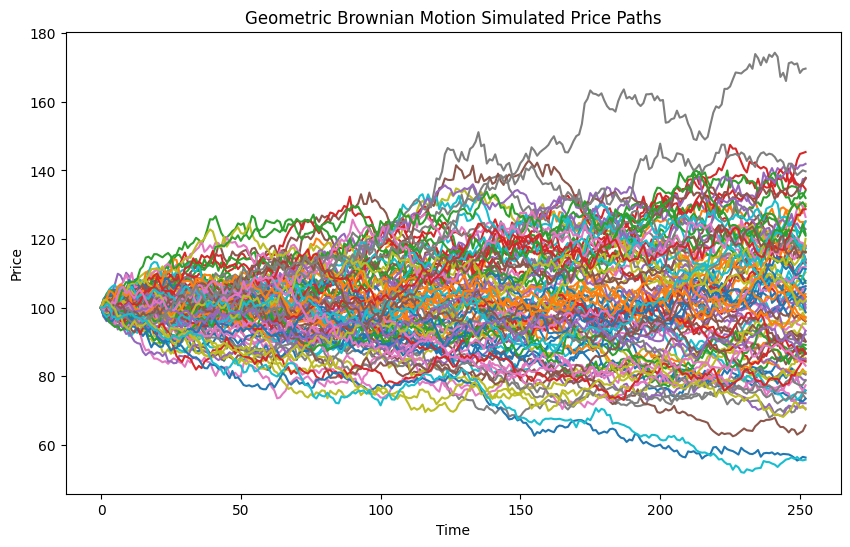

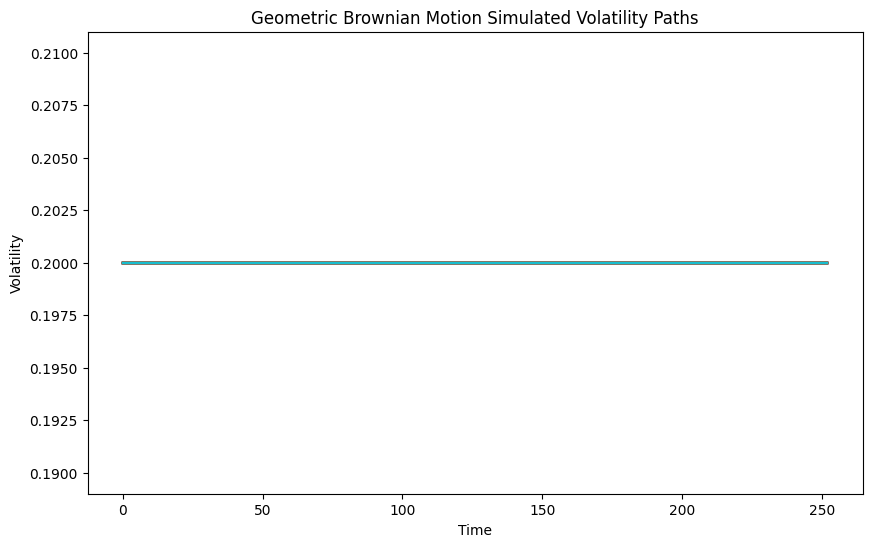

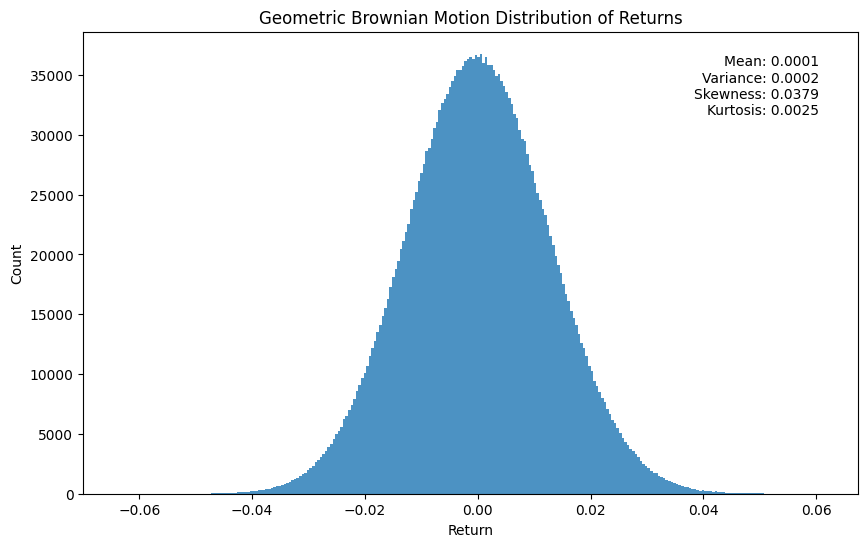

In [4]:
Sgmb = GeometricBrownianMotion(S0, r, T, sigma, Nt, Np)
Vgmb = np.full(Sgmb.shape, sigma ** 2)

PlotPricePaths(Sgmb, model = 'Geometric Brownian Motion')
PlotVolatilityPaths(Vgmb, model = 'Geometric Brownian Motion')
PlotReturnDistribution(Sgmb, model = 'Geometric Brownian Motion')

#### Heston Model

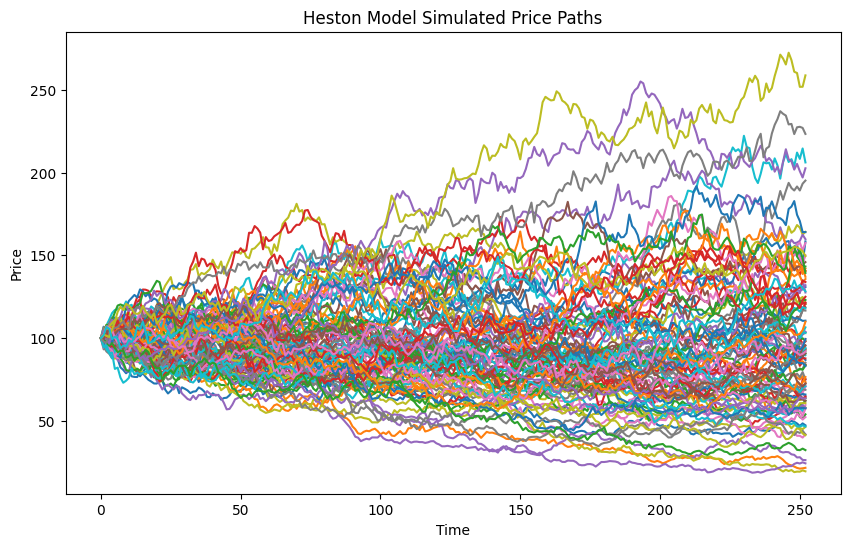

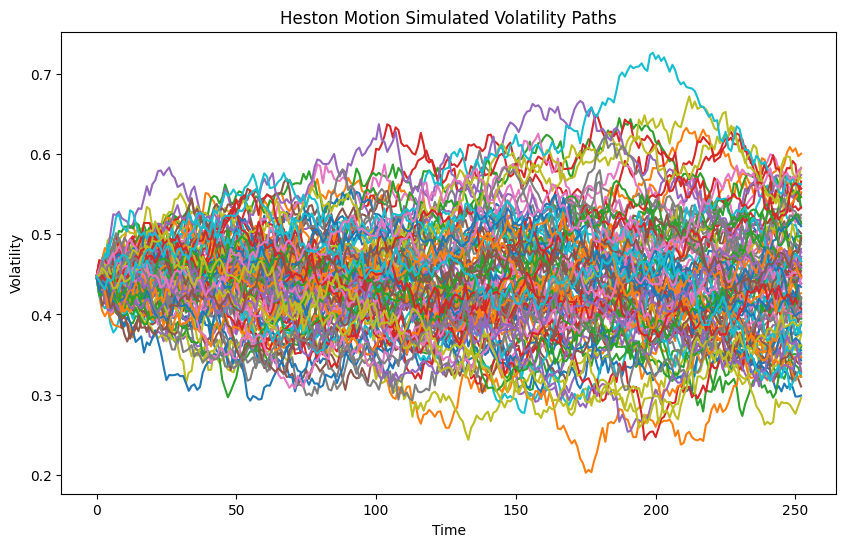

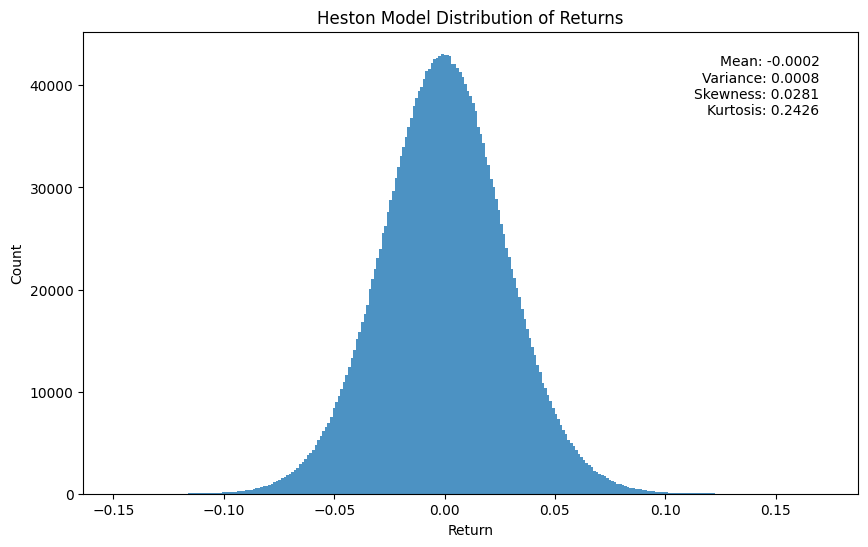

In [5]:
rho = -0.5
kappa = 2
c = 0.3

Sheston, Vheston = Heston(S0, r, T, sigma, rho, kappa, c, Nt, Np)

PlotPricePaths(Sheston, model = 'Heston Model')
PlotVolatilityPaths(Vheston, model = 'Heston Motion')
PlotReturnDistribution(Sheston, model = 'Heston Model')

#### GARCH(1,1) Model

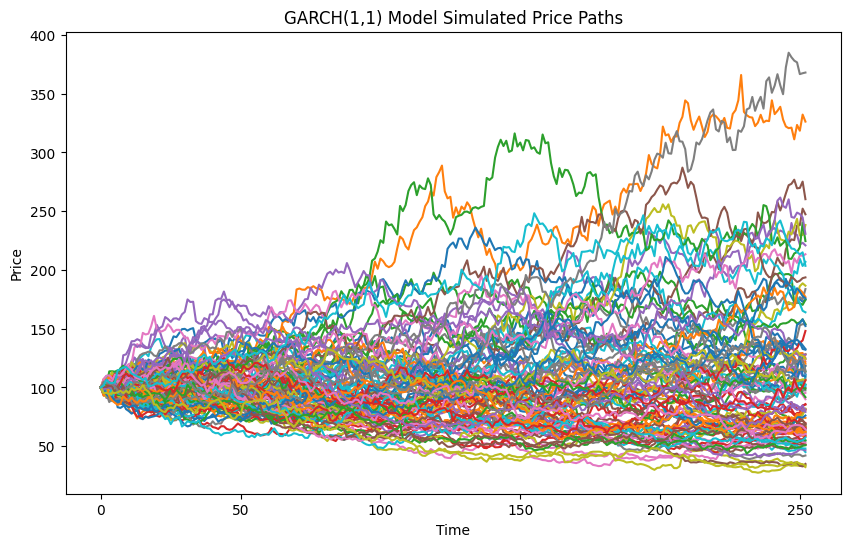

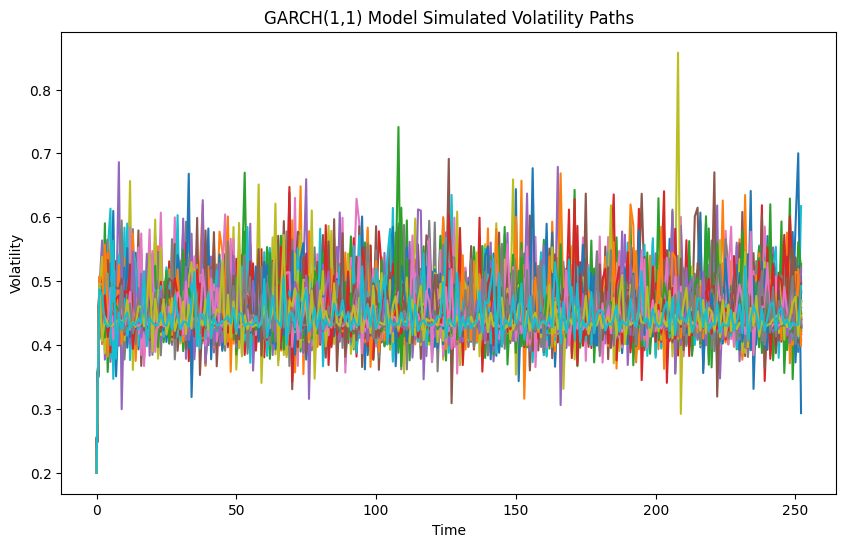

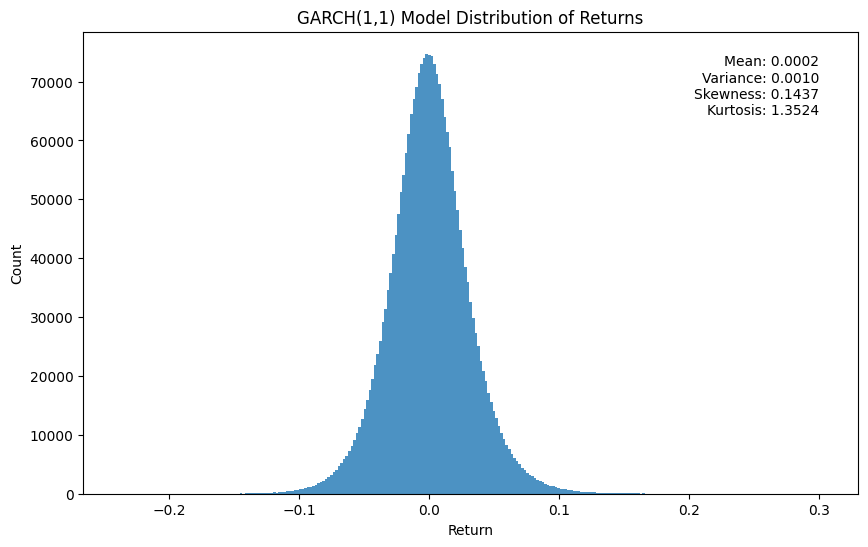

In [6]:
kappa = 1.25
alpha = 0.1

Sgarch, Vgarch = Garch(S0, r, T, sigma, kappa, alpha, Nt, Np)

PlotPricePaths(Sgarch, model = 'GARCH(1,1) Model')
PlotVolatilityPaths(Vgarch, model = 'GARCH(1,1) Model')
PlotReturnDistribution(Sgarch, model = 'GARCH(1,1) Model')

#### Deterministic Volatility Model

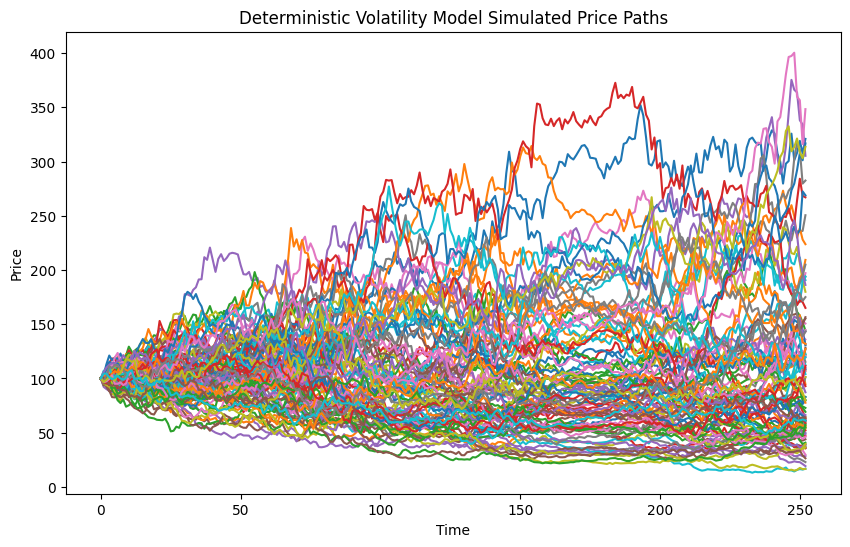

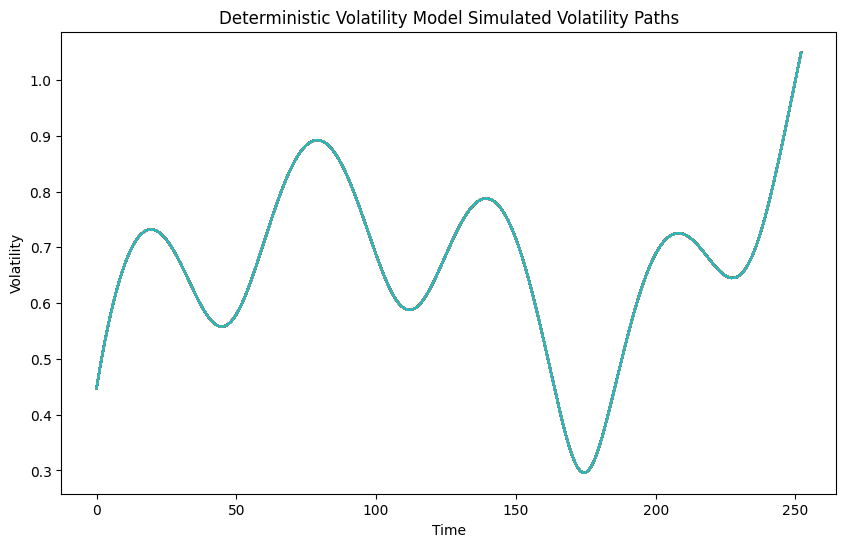

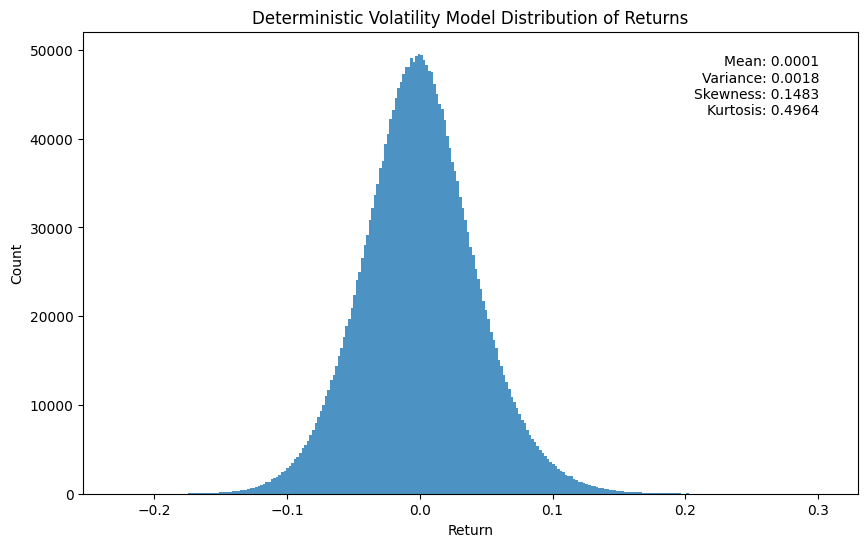

In [7]:
a, b, c, d, e = 2, -0.1, -10, 9, 0.2

Pdet, Vdet = Deterministic(S0, r, T, sigma, a, b, c, d, e, Nt, Np)

PlotPricePaths(Pdet, model = 'Deterministic Volatility Model')
PlotVolatilityPaths(Vdet, model = 'Deterministic Volatility Model')
PlotReturnDistribution(Pdet, model = 'Deterministic Volatility Model')

### Option Pricing

In [8]:
def VanillaOptionPrice(S, r, T, K, model):
    call = np.maximum(S[-1,:] - K, 0) * np.exp(-r * T)
    put = np.maximum(K - S[-1,:], 0) * np.exp(-r * T)

    return pd.DataFrame({
        'Call Option Price': np.mean(call),
        'Call Option Standard Error': np.std(call) / np.sqrt(S.shape[1]),
        'Put Option Price': np.mean(put),
        'Put Option Standard Error': np.std(put) / np.sqrt(S.shape[1])
    }, index = [model])

def BlackScholesMertonModel(S0, r, T, sigma, K):
    dplus = (np.log(S0 * np.exp(r * T) / K) / (sigma * np.sqrt(T))) + 0.5 * sigma * np.sqrt(T)
    dminus = (np.log(S0 * np.exp(r * T) / K) / (sigma * np.sqrt(T))) - 0.5 * sigma * np.sqrt(T)
    
    return pd.DataFrame({
        'Call Option Price': S0 * norm.cdf(dplus) - K * np.exp(-r * T) * norm.cdf(dminus),
        'Call Option Standard Error': np.nan,
        'Put Option Price': -S0 * norm.cdf(-dplus) + K * np.exp(-r * T) * norm.cdf(-dminus),
        'Put Option Standard Error': np.nan
    }, index = ['Black-Scholes Model'])

In [9]:
S0, r, T, Nt, Np = 100, 0.03, 1, 252, 10000
sigma = 0.2
K = 100

pd.concat([
    BlackScholesMertonModel(S0, r, T, sigma, K),
    VanillaOptionPrice(Sgmb, r, T, K, model = 'Geometric Brownian Motion'),
    VanillaOptionPrice(Sheston, r, T, K, model = 'Heston Model'),
    VanillaOptionPrice(Sgarch, r, T, K, model = 'GARCH(1,1) Model'),
    VanillaOptionPrice(Pdet, r, T, K, model = 'Deterministic Volatility Model')
    ])

,Call Option Price,Call Option Standard Error,Put Option Price,Put Option Standard Error
Black-Scholes Model,9.413403,NaN,6.457957,NaN
Geometric Brownian Motion,9.733804,0.143519,6.342376,0.093634
Heston Model,14.189026,0.272665,18.538210,0.207867
"GARCH(1,1) Model",22.278960,0.418766,16.738401,0.202028
Deterministic Volatility Model,26.916310,0.598953,24.681098,0.257673


### Implied Volatility

In [10]:
def VanillaCall(S, r, T, K):
    return np.mean(np.maximum(S[-1,:] - K, 0) * np.exp(-r * T))

def BlackScholesMertonCall(S0, r, T, sigma, K):
    dplus = (np.log(S0 * np.exp(r * T) / K) / (sigma * np.sqrt(T))) + 0.5 * sigma * np.sqrt(T)
    dminus = (np.log(S0 * np.exp(r * T) / K) / (sigma * np.sqrt(T))) - 0.5 * sigma * np.sqrt(T)
    return S0 * norm.cdf(dplus) - K * np.exp(-r * T) * norm.cdf(dminus)

def ImpliedVolatility(S0, r, T, K, mv):
    def loss(sigma):
        return (BlackScholesMertonCall(S0, r, T, sigma, K) - mv) ** 2
    
    result = minimize_scalar(loss, bounds = (1e-6, 2), method = 'bounded')
    return result.x if result.success else np.nan

def PlotSurface(df, x, y, z, model):
    X = df[x].unique()
    Y = df[y].unique()
    X, Y = np.meshgrid(X, Y)
    Z = df.pivot(index = x, columns = y, values = z).values

    fig = go.Figure(data = [go.Surface(z = Z, x = X, y = Y, colorscale = 'Viridis', showscale = False)])
    fig.update_layout(
        title = f'{model} {z} Surface',
        title_x = 0.5,
        title_xanchor = 'center',
        font = dict(
                color = 'black'
            ),
        scene = dict(
            xaxis_title = x, yaxis_title = y, zaxis_title = z,
            xaxis = dict(
                backgroundcolor = 'white', 
                gridcolor = 'grey',       
                showbackground = True,     
            ),
            yaxis = dict(
                backgroundcolor = 'white', 
                gridcolor = 'grey',       
                showbackground = True,     
            ),
            zaxis = dict(
                backgroundcolor = 'white', 
                gridcolor = 'grey',       
                showbackground = True,     
            )    
        ),
        height = 800
    )
    fig.show()


In [11]:
S0, r, Nt, Np = 100, 0.03, 252, 10000
sigma = 0.2

K = np.linspace(80, 120, 21)
T = np.linspace(0.25, 1.75, 21)

rd = 100

#### Geometric Brownian Motion

In [12]:
SURFgmb = []

for k in K:
    for t in T:
        S = GeometricBrownianMotion(S0, r, t, sigma, Nt, Np, rd)
        P = VanillaCall(S, r, t, k)
        IV = ImpliedVolatility(S0, r, t, k, P)
        SURFgmb.append({'Stock Price': S0, 'Strike': k, 'Moneyness': k / S0, 'Maturity': t, 'Call Price': P, 'Implied Volatility': IV})

SURFgmb = pd.DataFrame(SURFgmb)

In [13]:
PlotSurface(df = SURFgmb, x = 'Moneyness', y = 'Maturity', z = 'Call Price', model = 'Geometric Brownian Motion')
PlotSurface(df = SURFgmb, x = 'Moneyness', y = 'Maturity', z = 'Implied Volatility', model = 'Geometric Brownian Motion')

#### Heston Model

In [14]:
rho = -0.5
kappa = 2
c = 0.3

SURFheston = []

for k in K:
    for t in T:
        S, V = Heston(S0, r, t, sigma, rho, kappa, c, Nt, Np, rd)
        P = VanillaCall(S, r, t, k)
        IV = ImpliedVolatility(S0, r, t, k, P)
        SURFheston.append({'Stock Price': S0, 'Strike': k, 'Moneyness': k / S0, 'Maturity': t, 'Call Price': P, 'Implied Volatility': IV})

SURFheston = pd.DataFrame(SURFheston)

In [15]:
PlotSurface(df = SURFheston, x = 'Moneyness', y = 'Maturity', z = 'Call Price', model = 'Heston Model')
PlotSurface(df = SURFheston, x = 'Moneyness', y = 'Maturity', z = 'Implied Volatility', model = 'Heston Model')

#### GARCH(1,1) Model

In [16]:
kappa = 1.25
alpha = 0.1

SURFgarch = []

for k in K:
    for t in T:
        S, V = Garch(S0, r, t, sigma, kappa, alpha, Nt, Np, rd)
        P = VanillaCall(S, r, t, k)
        IV = ImpliedVolatility(S0, r, t, k, P)
        SURFgarch.append({'Stock Price': S0, 'Strike': k, 'Moneyness': k / S0, 'Maturity': t, 'Call Price': P, 'Implied Volatility': IV})

SURFgarch = pd.DataFrame(SURFgarch)

In [17]:
PlotSurface(df = SURFgarch, x = 'Moneyness', y = 'Maturity', z = 'Call Price', model = 'GARCH(1,1) Model')
PlotSurface(df = SURFgarch, x = 'Moneyness', y = 'Maturity', z = 'Implied Volatility', model = 'GARCH(1,1) Model')

#### Deterministic Volatility Model

In [18]:
a, b, c, d, e = 2, -0.1, -10, 9, 0.2

SURFdet = []

for k in K:
    for t in T:
        S, V = Deterministic(S0, r, t, sigma, a, b, c, d, e, Nt, Np, rd)
        P = VanillaCall(S, r, t, k)
        IV = ImpliedVolatility(S0, r, t, k, P)
        SURFdet.append({'Stock Price': S0, 'Strike': k, 'Moneyness': k / S0, 'Maturity': t, 'Call Price': P, 'Implied Volatility': IV})

SURFdet = pd.DataFrame(SURFdet)

In [19]:
PlotSurface(df = SURFgarch, x = 'Moneyness', y = 'Maturity', z = 'Call Price', model = 'Deterministic Volatility Model')
PlotSurface(df = SURFgarch, x = 'Moneyness', y = 'Maturity', z = 'Implied Volatility', model = 'Deterministic Volatility Model')